In [1]:
import pandas as pd  
import numpy as np
import datetime
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt
from utils.utils import PROJECT_DATA_DIR
import os
%matplotlib inline

In [2]:
df = pd.read_csv(os.path.join(PROJECT_DATA_DIR, 'closing_prices.csv'))
df.set_index('date', inplace=True)
tickers = ['AAPL', 'ABBV', 'AMZN', 'GOOG']
#tickers = df.columns
df = df[tickers]
df.head()

,AAPL,ABBV,AMZN,GOOG
date,,,,
2010-01-04,27.294495,NaN,133.90,NaN
2010-01-05,27.341684,NaN,134.69,NaN
2010-01-06,26.906778,NaN,132.25,NaN
2010-01-07,26.857038,NaN,130.00,NaN
2010-01-08,27.035592,NaN,133.52,NaN


In [3]:
def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio


def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns) + 3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0, i] = portfolio_return
        results_matrix[1, i] = portfolio_std
        results_matrix[2, i] = sharpe_ratio
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j + 3, i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T, columns=['ret', 'stdev', 'sharpe'] + [ticker for ticker in tickers])
        
    return results_df

In [4]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.0
results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)

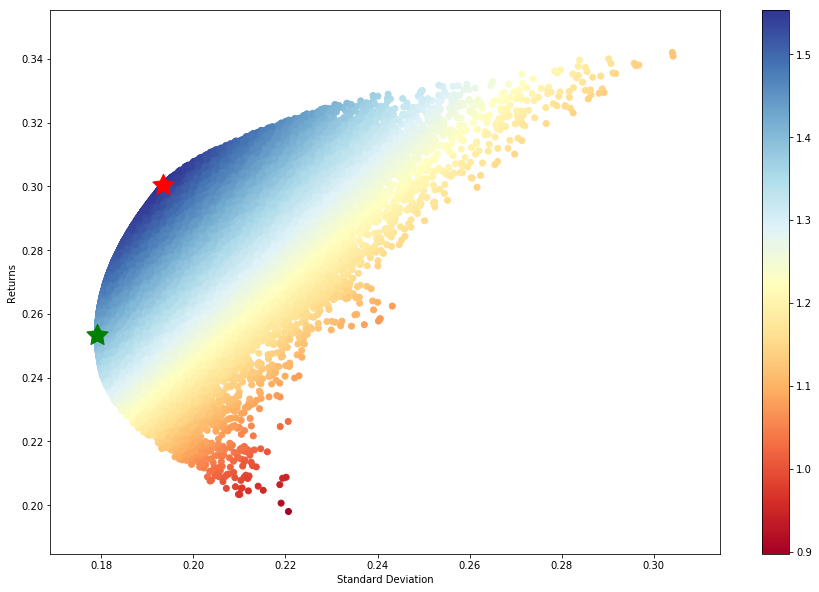

In [5]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(15, 10))
plt.scatter(results_frame.stdev, results_frame.ret, c=results_frame.sharpe, cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5, 1, 0), color='r', s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1], min_vol_port[0], marker=(5, 1, 0), color='g', s=500)
plt.show()

In [6]:
max_sharpe_port.to_frame().T

,ret,stdev,sharpe,AAPL,ABBV,AMZN,GOOG
4618,0.300513,0.193497,1.553065,0.310395,0.406961,0.278161,0.004483


In [7]:
min_vol_port.to_frame().T

,ret,stdev,sharpe,AAPL,ABBV,AMZN,GOOG
16769,0.253232,0.179138,1.413617,0.30836,0.289089,0.052458,0.350093


In [8]:
def calc_neg_sharpe(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

def max_sharpe_ratio(mean_returns, cov, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_neg_sharpe, num_assets * [1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

optimal_port_sharpe = max_sharpe_ratio(mean_returns, cov, rf)



In [9]:
pd.DataFrame([round(x,2) for x in optimal_port_sharpe['x']], index=tickers).T

,AAPL,ABBV,AMZN,GOOG
0,0.32,0.41,0.28,0.0


In [10]:
def calc_portfolio_std(weights, mean_returns, cov):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    return portfolio_std  

def min_variance(mean_returns, cov):
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_std, num_assets * [1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

min_port_variance = min_variance(mean_returns, cov)

In [11]:
pd.DataFrame([round(x,2) for x in min_port_variance['x']], index=tickers).T


,AAPL,ABBV,AMZN,GOOG
0,0.31,0.29,0.05,0.35


In [12]:
def calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_return, portfolio_std, portfolio_var


def simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, portfolio_VaR = calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days)
        results_matrix[0, i] = portfolio_return
        results_matrix[1, i] = portfolio_std
        results_matrix[2, i] = portfolio_VaR
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j + 3, i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','VaR'] + [ticker for ticker in tickers])
        
    return results_df

In [13]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.0
days = 252
alpha = 0.05
results_frame = simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days)

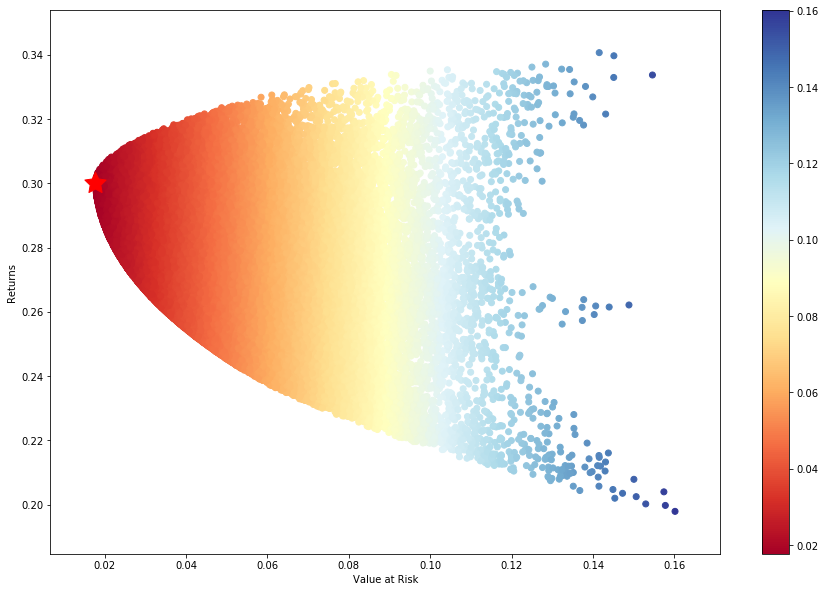

In [14]:
#locate positon of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by VaR
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.VaR, results_frame.ret, c=results_frame.VaR, cmap='RdYlBu')
plt.xlabel('Value at Risk')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[2], min_VaR_port[0], marker=(5, 1, 0), color='r', s=500)
plt.show()

In [15]:
min_VaR_port.to_frame().T

,ret,stdev,VaR,AAPL,ABBV,AMZN,GOOG
78670,0.300283,0.193341,0.017735,0.314125,0.406809,0.275075,0.003991


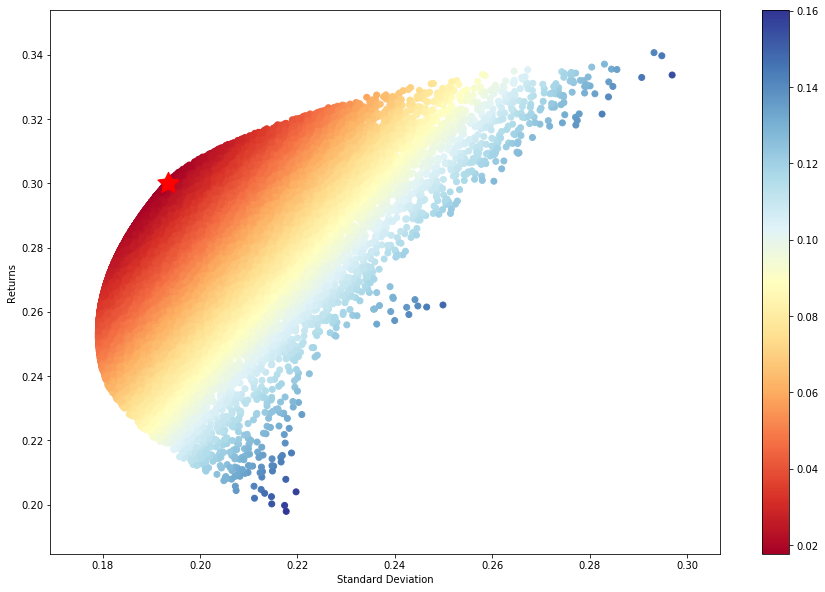

In [16]:
#locate positon of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by VaR
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev, results_frame.ret, c=results_frame.VaR, cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[1], min_VaR_port[0], marker=(5, 1, 0), color='r', s=500)
plt.show()

In [17]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

def calc_portfolio_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var


def min_VaR(mean_returns, cov, alpha, days):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, days)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets * [1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

min_port_VaR = min_VaR(mean_returns, cov, alpha, days)

In [18]:
pd.DataFrame([round(x, 2) for x in min_port_VaR['x']], index=tickers).T

,AAPL,ABBV,AMZN,GOOG
0,0.32,0.41,0.27,0.0
